# 1. Data preparation and exploration 

## 1.1

In [78]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment-2A"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).set('spark.sql.files.maxPartitionBytes' , '62074651').setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()


sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')


In [2]:
#importng needed functions
from pyspark.sql.functions import isnan, when, count, col,rand
from pyspark.sql.types import *
from pyspark.sql import functions as sf
from pyspark.sql.functions import *
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.mllib.evaluation import BinaryClassificationMetrics


### 1.2

### 1

In [3]:
#schema for process df
customSchema_process = StructType([
    StructField("ts", FloatType(), True),
    StructField("PID", FloatType(), True),
    StructField("TRUN", FloatType(), True),
    StructField("TSLPI", FloatType(), True),
    StructField("TSLPU", FloatType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", FloatType(), True),
    StructField("PRI", FloatType(), True),
    StructField("RTPR", FloatType(), True),
    StructField("CPUNR", FloatType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", FloatType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", FloatType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", FloatType(), True),    
    StructField("type", StringType(), True)
])

In [4]:
#schema for memory df

customSchema_memory = StructType([
    StructField("ts", FloatType(), True),
    StructField("PID", FloatType(), True),
    StructField("MINFLT", FloatType(), True),
    StructField("MAJFLT", FloatType(), True),
    StructField("VSTEXT", FloatType(), True),
    StructField("VSIZE", FloatType(), True),
    StructField("RSIZE", FloatType(), True),
    StructField("VGROW", FloatType(), True),
    StructField("RGROW", FloatType(), True),
    StructField("MEM", FloatType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", FloatType(), True),    
    StructField("type", StringType(), True)
])

In [5]:
#Load the CSV File
memory_df = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .schema(customSchema_memory)\
            .load('*_memory*.csv').cache()

In [6]:
#Load the CSV File
process_df = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .schema(customSchema_process)\
            .load('*_process*.csv').cache()

In [7]:
#1.2 - 1
print("Row count of memory df ------------\n")
print(memory_df.count())
print("Row count of process df ------------\n")
print(process_df.count())

Row count of memory df ------------

2000000
Row count of process df ------------

1927968


In [8]:
memory_df.printSchema()

root
 |-- ts: float (nullable = true)
 |-- PID: float (nullable = true)
 |-- MINFLT: float (nullable = true)
 |-- MAJFLT: float (nullable = true)
 |-- VSTEXT: float (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: float (nullable = true)
 |-- type: string (nullable = true)



In [9]:
process_df.printSchema()

root
 |-- ts: float (nullable = true)
 |-- PID: float (nullable = true)
 |-- TRUN: float (nullable = true)
 |-- TSLPI: float (nullable = true)
 |-- TSLPU: float (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: float (nullable = true)
 |-- PRI: float (nullable = true)
 |-- RTPR: float (nullable = true)
 |-- CPUNR: float (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: float (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: float (nullable = true)
 |-- type: string (nullable = true)



### 2

In [10]:
#nulls checking in memory_df
memory_df.select([memory_df[x].isNull() for x in memory_df.columns]).show()

+------------+-------------+----------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+-------------+----------------+--------------+
|(ts IS NULL)|(PID IS NULL)|(MINFLT IS NULL)|(MAJFLT IS NULL)|(VSTEXT IS NULL)|(VSIZE IS NULL)|(RSIZE IS NULL)|(VGROW IS NULL)|(RGROW IS NULL)|(MEM IS NULL)|(CMD IS NULL)|(attack IS NULL)|(type IS NULL)|
+------------+-------------+----------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+-------------+----------------+--------------+
|       false|        false|           false|           false|           false|          false|          false|          false|          false|        false|        false|           false|         false|
|       false|        false|           false|           false|           false|          false|          false|          false|          false|        false|        false|           fa

In [11]:
#count of nulls in rach column in memory_df
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|  8800|  8800|    0| 9728|49552| 9737|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [12]:
#nulls checking in process_df

process_df.select([process_df[x].isNull() for x in process_df.columns]).show()

+------------+-------------+--------------+---------------+---------------+--------------+--------------+-------------+--------------+---------------+----------------+-------------+---------------+-------------+-------------+----------------+--------------+
|(ts IS NULL)|(PID IS NULL)|(TRUN IS NULL)|(TSLPI IS NULL)|(TSLPU IS NULL)|(POLI IS NULL)|(NICE IS NULL)|(PRI IS NULL)|(RTPR IS NULL)|(CPUNR IS NULL)|(Status IS NULL)|(EXC IS NULL)|(State IS NULL)|(CPU IS NULL)|(CMD IS NULL)|(attack IS NULL)|(type IS NULL)|
+------------+-------------+--------------+---------------+---------------+--------------+--------------+-------------+--------------+---------------+----------------+-------------+---------------+-------------+-------------+----------------+--------------+
|       false|        false|         false|          false|          false|         false|         false|        false|         false|          false|           false|        false|          false|        false|        false| 

In [13]:
#count of nulls in rach column in process_df

process_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in process_df.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



Hence we see that there are a lot of Null values in the dataframe memory_df. To see what is wrong I have created the dataframes again without the schema loading. 

In [14]:
#Load the CSV File
memory_df = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('*_memory*.csv').cache()

In [15]:
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



**Now there are no null values in any dataframe's columns. Hence when I looked at the data more deeply I saw that there are certain values that are like 100K, 132K, etc. Hence when converted to FloatType() before, they become null and hence we saw a huge count of Nulls. However when a StringType() is used for them then they are fine. Hence we need to extract the values with such problems, correct them and then finally convert it into the correct data type.**

**Also I have seen that there are certain spaces between the values in the column VGROW. To handle it I have simply replaced spaces with ""**

**Hence now the columns MINFLT, MAJFLT, VSTEXT, RSIZE, VGROW and RGROW are not in the desired data types. We will first transform/wrangle them and then convert them to the data type as per the metadata file**

In [16]:
udf_for_m = udf(lambda val: str(float(val.replace("M", ""))*1000000) if "M" in val else val, StringType())
memory_df = memory_df.withColumn("MINFLT", udf_for_m("MINFLT"))
memory_df = memory_df.withColumn("MAJFLT", udf_for_m("MAJFLT"))
memory_df = memory_df.withColumn("VSTEXT", udf_for_m("VSTEXT"))
memory_df = memory_df.withColumn("RSIZE", udf_for_m("RSIZE"))
memory_df = memory_df.withColumn("VGROW", udf_for_m("VGROW"))
memory_df = memory_df.withColumn("RGROW", udf_for_m("RGROW"))



udf_for_k = udf(lambda val: str(float(val.replace("K", ""))*1000) if "K" in val else val, StringType())
memory_df = memory_df.withColumn("MINFLT", udf_for_k("MINFLT"))
memory_df = memory_df.withColumn("MAJFLT", udf_for_k("MAJFLT"))
memory_df = memory_df.withColumn("VSTEXT", udf_for_k("VSTEXT"))
memory_df = memory_df.withColumn("RSIZE", udf_for_k("RSIZE"))
memory_df = memory_df.withColumn("VGROW", udf_for_k("VGROW"))
memory_df = memory_df.withColumn("RGROW", udf_for_k("RGROW"))

udf_for_space = udf(lambda val: val.replace(" ", "") if " " in val else val)
memory_df = memory_df.withColumn("MINFLT", udf_for_space("MINFLT"))
memory_df = memory_df.withColumn("MAJFLT", udf_for_space("MAJFLT"))
memory_df = memory_df.withColumn("VSTEXT", udf_for_space("VSTEXT"))
memory_df = memory_df.withColumn("RSIZE", udf_for_space("RSIZE"))
memory_df = memory_df.withColumn("VGROW", udf_for_space("VGROW"))
memory_df = memory_df.withColumn("RGROW", udf_for_space("RGROW"))


memory_df = memory_df.withColumn("MINFLT", memory_df["MINFLT"].cast(FloatType()))
memory_df = memory_df.withColumn("MAJFLT", memory_df["MAJFLT"].cast(FloatType()))
memory_df = memory_df.withColumn("VSTEXT", memory_df["VSTEXT"].cast(FloatType()))
memory_df = memory_df.withColumn("MINFLT", memory_df["MINFLT"].cast(FloatType()))
memory_df = memory_df.withColumn("RSIZE", memory_df["RSIZE"].cast(FloatType()))
memory_df = memory_df.withColumn("VGROW", memory_df["VGROW"].cast(FloatType()))
memory_df = memory_df.withColumn("RGROW", memory_df["RGROW"].cast(FloatType()))

In [17]:
#converting the remaining columns to the desired data type
memory_df = memory_df.withColumn("ts", memory_df["ts"].cast(FloatType()))
memory_df = memory_df.withColumn("PID", memory_df["PID"].cast(FloatType()))
memory_df = memory_df.withColumn("VSIZE", memory_df["VSIZE"].cast(FloatType()))
memory_df = memory_df.withColumn("MEM", memory_df["MEM"].cast(FloatType()))
memory_df = memory_df.withColumn("attack", memory_df["attack"].cast(FloatType()))

In [18]:
memory_df.printSchema()

root
 |-- ts: float (nullable = true)
 |-- PID: float (nullable = true)
 |-- MINFLT: float (nullable = true)
 |-- MAJFLT: float (nullable = true)
 |-- VSTEXT: float (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: float (nullable = true)
 |-- type: string (nullable = true)



In [19]:
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



**Hence now the memory_df is correct with no null values and correct data types of the columns**

## 1.3

### 1

In [20]:
#memory df group by attack to see count of each attack 
memory_df.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|   1.0| 205623|
|   0.0|1794377|
+------+-------+



In [21]:
#process df group by attack to see count of each attack 
process_df.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|   1.0| 291364|
|   0.0|1636604|
+------+-------+



In [22]:
process_df.groupBy('type').count().show()

+---------+-------+
|     type|  count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



**CLASS IMBALANCE -**

**We can see that non attacks are almost 8 and 5 times respectively in memory_df and process_df as compared to the ataacks. Hence there is class imbalance present as the data is not equally divided.**

**We can see that the type mitm occurs very less while the dos and ddos occur frequently. Hence there is class imbalance.**

**mitm occurs just 0.0058% of times while the highest occurs 3.7139% of times(when considering attacks only)**

**Also we see that 84.8875% of times there was no attack involved hence only 15.1125% of times there was an attack involved.**



In [23]:
total_process = process_df.count()
process_df_percent = process_df.groupBy('type').count().withColumn('Percentage', sf.round((sf.col('count') / total_process) * 100,4) )\
                            .orderBy('Percentage')
process_df_percent.show()

+---------+-------+----------+
|     type|  count|Percentage|
+---------+-------+----------+
|     mitm|    112|    0.0058|
|      xss|  17759|    0.9211|
| scanning|  38449|    1.9943|
|injection|  41311|    2.1427|
| password|  51409|    2.6665|
|      dos|  70721|    3.6682|
|     ddos|  71603|    3.7139|
|   normal|1636604|   84.8875|
+---------+-------+----------+



### 2

In [24]:
#basic statistics of numreic features in process_df

list_cols = []
for x in process_df.dtypes:
    if x[1] == 'float' and x[0] != 'attack' and x[0] != 'type':
        list_cols = list_cols + [x[0]]
        
process_df.select(list_cols).cache().describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311846504E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527309440533
2,stddev,771350.0251386948,4987.784329320414,0.24782587090416136,6.988459728531831,0.044218744192145984,8.403189864752061,22.624445062102893,0.0,1.5274047225903082,1.4619498567691886,0.1362894380620314
3,min,1.55421683E9,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,1.55759296E9,53080.0,12.0,70.0,21.0,20.0,139.0,0.0,5.0,127.0,4.02


In [25]:
#basic statistics of numric features in memory_df

list_cols = []
for x in memory_df.dtypes:
    if x[1] == 'float' and x[0] != 'attack' and x[0] != 'type':
        list_cols = list_cols + [x[0]]
        
memory_df.select(list_cols).cache().describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707872E9,4999.360446,983.344344,987846.5873270228,46453.2741520752,4496.419966548507,23722.88866416576,984.4668735599683,483.1746625500008,0.003385164946130477
2,stddev,984463.369363614,4887.313351921471,19229.610980642283,1.484287423809903E7,658730.205154302,9046.338093354187,1986383.180873514,86174.82585202338,1491.476105917185,0.010943425702315
3,min,1.55421683E9,1007.0,0.0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1.55835571E9,53096.0,8050000.0,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [26]:
#top 10 values and corresponing counts of non-numric features in process_df
for x in process_df.dtypes:
    if x[1] != 'float' and x[0] != 'attack' and x[0] != 'type':
        process_df.groupby(x[0]).count().withColumnRenamed("count","count").sort(desc("count")).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [27]:
#top 10 values and corresponing counts of non-numric features in memory_df
for x in memory_df.dtypes:
    if x[1] != 'float' and x[0] != 'attack' and x[0] != 'type':
        memory_df.groupby(x[0]).count().withColumnRenamed("count","count").sort(desc("count")).show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



### 3

In [28]:
#pip install seaborn
memory_df.printSchema()

root
 |-- ts: float (nullable = true)
 |-- PID: float (nullable = true)
 |-- MINFLT: float (nullable = true)
 |-- MAJFLT: float (nullable = true)
 |-- VSTEXT: float (nullable = true)
 |-- VSIZE: float (nullable = true)
 |-- RSIZE: float (nullable = true)
 |-- VGROW: float (nullable = true)
 |-- RGROW: float (nullable = true)
 |-- MEM: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: float (nullable = true)
 |-- type: string (nullable = true)



In [29]:
process_df.printSchema()

root
 |-- ts: float (nullable = true)
 |-- PID: float (nullable = true)
 |-- TRUN: float (nullable = true)
 |-- TSLPI: float (nullable = true)
 |-- TSLPU: float (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: float (nullable = true)
 |-- PRI: float (nullable = true)
 |-- RTPR: float (nullable = true)
 |-- CPUNR: float (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: float (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: float (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: float (nullable = true)
 |-- type: string (nullable = true)



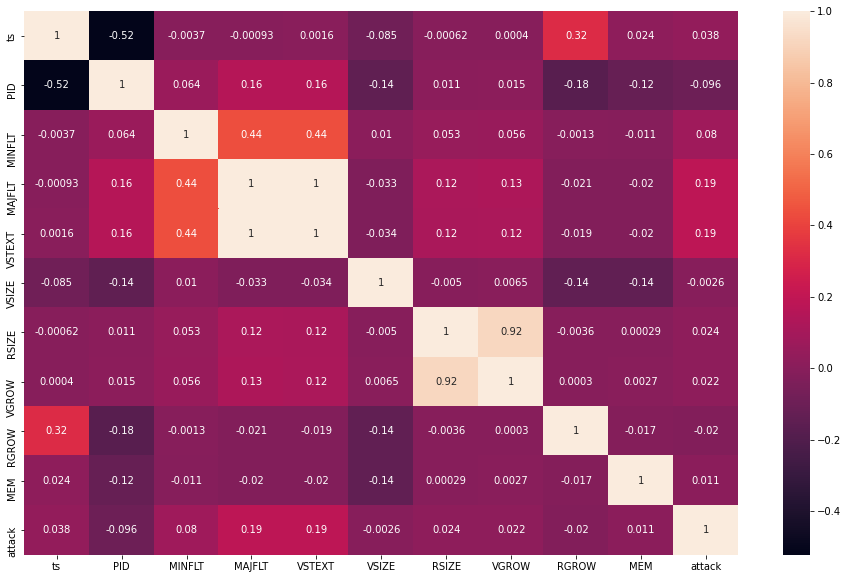

In [30]:
# CORRELATION GRAPHS
memory_df_pandas = memory_df.sample(0.1).toPandas()
plt.figure(figsize = (16,10))
ax = sns.heatmap(memory_df_pandas.corr(), annot = True)



From the above correlation plot for all the columns in process_df we can see how the different columns are related to the column attack. A positive correlation means that the two columns are dependent such that if one increases/decreases then other increases/decreases. A negative correlation means that if one increases/decreases then other decreases/increases. Setting a significance of 0.01 I have selected columns that show high positive and high negative correlation. From the graph I have selected columns - MINFLT MAJFLT VSTEXT RSIZE VGROW RGROW MEM. They are hence related to the attack column significantly.

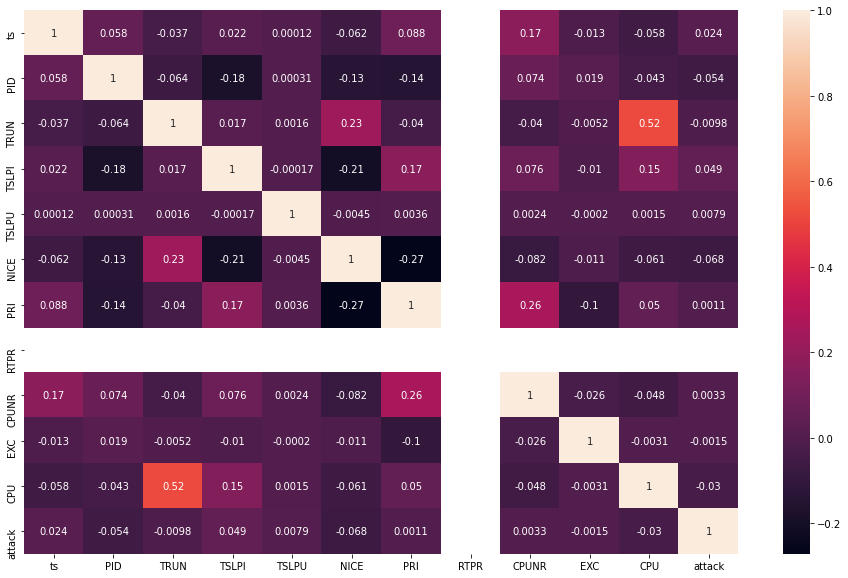

In [32]:
# CORRELATION GRAPHS

process_df_pandas = process_df.sample(0.1).toPandas()
plt.figure(figsize = (16,10))
ax = sns.heatmap(process_df_pandas.corr(), annot = True)

From the above correlation plot for all the columns in memory_df we can see how the different columns are related to the column attack. Setting a significance of 0.005 I have selected columns that show high positive and high negative correlation. I have choosen 0.005 significance, as the correlation values were very less for the different columns with attack column and hence to get the significant columns I have done so. From the graph I have selected columns -TRUN TSLPI TSLPU NICE CPU. They are hence related to the attack column significantly.

<AxesSubplot:xlabel='type', ylabel='count'>

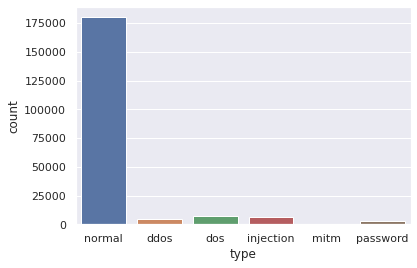

In [88]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=memory_df_pandas)

Hence from the graph we can see that normal type of attack occurs the most times which basically represents no attack section. While the other type of attacks occur very less. injection type still occurs more frequently than the other ones.

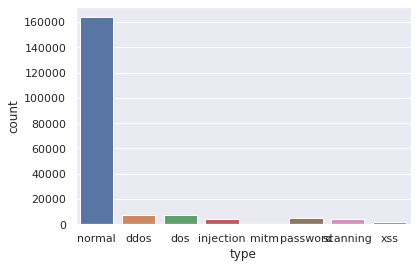

In [81]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=process_df_pandas)

Hence from the graph we can see that normal type of attack occurs the most times which basically represents no attack section. While the other type of attacks occur very less. dos and ddos type still occurs more frequently than the other ones.

# 2. Feature extraction and ML training

## 2.1

### 1

In [34]:
memory_train, memory_test = memory_df.randomSplit([0.8, 0.2],seed = 15)
process_train, process_test = process_df.randomSplit([0.8, 0.2],seed = 15)

### 2

In [39]:
# rebalanced training data for memory_train
attack = memory_train.filter(col('attack') == 1).sample(0.2,seed = 15)
non_attack = memory_train.filter(col('attack') == 0)
if non_attack.count() > attack.count():
    ratio = non_attack.count()/attack.count()
else:
    ratio = attack.count()/non_attack.count()


In [41]:
#count of each event in rebalanced_memory_train 
sampled_non_attack = non_attack.sample(False, 1/(ratio/2),seed = 15)
rebalanced_memory_train = sampled_non_attack.unionAll(attack)
rebalanced_memory_train.groupby('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|   1.0|32911|
|   0.0|65910|
+------+-----+



In [42]:
# rebalanced training data for process_train
attack2 = process_train.filter(col('attack') == 1).sample(0.2,seed = 15)
non_attack2 = process_train.filter(col('attack') == 0)
if non_attack2.count() > attack2.count():
    ratio2 = non_attack2.count()/attack2.count()
else:
    ratio2 = attack2.count()/non_attack2.count()


In [43]:
#count of each event in rebalanced_process_train 

sampled_non_attack2 = non_attack2.sample(False, 1/(ratio2/2),seed = 15)
rebalanced_process_train = sampled_non_attack2.unionAll(attack2)
rebalanced_process_train.groupby('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|   1.0|46613|
|   0.0|93261|
+------+-----+



## 2.2

### 1

**Final Features Selected for process_df are - ['TSLPI' , 'NICE','PRI', 'POLY']**

**Final Features Selected for memory_df are - ['MINFLT', 'MAJFLT', 'VSTEXT' , 'RSIZE','VGROW','RGROW','MEM']**

**From the graphs plotted in 1.3.1 I have selected columns which show a good significance to the attack column. This would mean that the columns have a strong positive or negative effect to the attack column. Also I have ignored the columns ts, PID and type as they do not have sinificance to the attack column in both the dataframes. They represent time stamps and ids which will not effect whether an attack occurs or not. Also the type of the attack will not have any significance to the attack column. I hav also selected the features with the help of the describe funtion used above. It tells us that if a feature has a high standard deviation, then the feature is significant.** 

Talking about the process_df I have selected the columns - 'TSLPI', 'NICE', 'PRI' and 'POLY'. This is because these column show a high significance to the attack column as can be seen from the correlation graph. TSLPI and NICE have the correlation values near to 0.05 significance, where TSLPI has a positive correlation and NICE has a negative correlatin value. Hence they will have a strong positive and negative effect on the attack column. Also the column PRI and POLY have high standard deviation values as can be seen from the describe() used. Hence a strong standard deviation will mean that the values will signify the target variable. Hence these columns have been selected finally to train into the pipeline models. Also these columns have high range values and hence they will be scaled after the vectorassembler process.

Talking about the memory_df I have selected the columns 'MINFLT', 'MAJFLT', 'VSTEXT' , 'RSIZE','VGROW','RGROW' and 'MEM'. All these columns show a high standard deviation to the attack column. Hence they will strongly effect the attack column. Also making use of the observations from the correlaton graph it can be seen that all these features show a sinificance level of approximately 0.01 in positive or negative effects. Hence these columns have been selected finally to train into the pipeline models. Also these columns have high range values and hence they will be scaled after the vectorassembler process.

### 2 and 3 for process_train

In [46]:
# TRANSFORMERS FOR SELECTED FEATURES FOR PROCESS_TRAIN

#Define the input columns
inputCols=['POLI']
#Define the output columns 
outputCols=['POLI_index']
inputCols_OHE = [y for y in outputCols if y!='attack_index']
outputCols_OHE = [f'{x}_vec' for x in inputCols if x!='attack']


inputCols_VA = [x for x in outputCols_OHE]
inputCols_VA = inputCols_VA + ['TSLPI' , 'NICE','PRI'] 



indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)
encoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)
#Define the assembler with appropriate input and output columns
assembler = VectorAssembler(
    inputCols=inputCols_VA,
    outputCol="features")


scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')



### 3

In [47]:
# DECISION TREE AND GRADIENT BOOSTED TREE FOR SELECTED FEATURES FOR PROCESS_TRAIN

dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack', maxDepth = 3)
pipeline_process_dt = Pipeline(stages = [indexer,encoder,assembler,scaler,dt])


gbt = GBTClassifier(labelCol="attack", featuresCol="scaledFeatures", maxIter=10)
pipeline_process_gbt = Pipeline(stages = [indexer,encoder,assembler,scaler,gbt])


### 2 AND 3 FOR memory_train

In [48]:
# TRANSFORMERS FOR SELECTED FEATURES FOR MEMORY_TRAIN


inputCols_VA_mem = ['MINFLT', 'MAJFLT', 'VSTEXT' , 'RSIZE','VGROW','RGROW','MEM'] 

#Define the assembler with appropriate input and output columns
assembler = VectorAssembler(
    inputCols=inputCols_VA_mem,
    outputCol="features")

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')



In [49]:
# DECISION TREE AND GRADIENT BOOSTED TREE FOR SELECTED FEATURES FOR PROCESS_TRAIN

dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack', maxDepth = 3)
pipeline_memory_dt = Pipeline(stages = [assembler,scaler,dt])


gbt = GBTClassifier(labelCol="attack", featuresCol="scaledFeatures", maxIter=10)
pipeline_memory_gbt = Pipeline(stages = [assembler,scaler,gbt])


## 2.3

### 1

In [50]:

pipelineModel_dt_process = pipeline_process_dt.fit(rebalanced_process_train)


pipelineModel_gbt_process =  pipeline_process_gbt.fit(rebalanced_process_train)


In [51]:

pipelineModel_dt_memory = pipeline_memory_dt.fit(rebalanced_memory_train)


pipelineModel_gbt_memory =  pipeline_memory_gbt.fit(rebalanced_memory_train)


### 2

In [52]:
#testing on Decision Tree pipeline of process_test

predictions_process_dt = pipelineModel_dt_process.transform(process_test)
predictions_process_dt.show()


+------------+-------+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---------+------+------+----------+-------------+-------------+--------------------+-----------------+--------------------+----------+
|          ts|    PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|      CMD|attack|  type|POLI_index|     POLI_vec|     features|      scaledFeatures|    rawPrediction|         probability|prediction|
+------------+-------+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---------+------+------+----------+-------------+-------------+--------------------+-----------------+--------------------+----------+
|1.55421683E9|11564.0| 0.0|  0.0|  0.0|   0| 0.0|0.0| 0.0|  0.0|    NE|0.0|    E|0.0|     <cp>|   0.0|normal|       1.0|(2,[1],[1.0])|(5,[1],[1.0])|(5,[1],[6.0395202...|[67883.0,36619.0]|[0.64958565386308...|       0.0|
|1.55421696E9|11569.0| 0.0|  0.0|  0.0|   0| 0.0|0.0| 0.0|  0.0|    NE|0.0|    E|0.0|     <cp>|   0.0|normal|       1.0|

In [53]:
predictions_process_dt.groupby(['attack','prediction']).count().show()


+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       0.0| 55630|
|   0.0|       0.0|319570|
|   1.0|       1.0|  2801|
|   0.0|       1.0|  7712|
+------+----------+------+



In [54]:
#testing on Grdient boosted Tree pipeline of process_test

predictions_process_gbt = pipelineModel_gbt_process.transform(process_test)
predictions_process_gbt.show()

+------------+-------+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---------+------+------+----------+-------------+-------------+--------------------+--------------------+--------------------+----------+
|          ts|    PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|      CMD|attack|  type|POLI_index|     POLI_vec|     features|      scaledFeatures|       rawPrediction|         probability|prediction|
+------------+-------+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---------+------+------+----------+-------------+-------------+--------------------+--------------------+--------------------+----------+
|1.55421683E9|11564.0| 0.0|  0.0|  0.0|   0| 0.0|0.0| 0.0|  0.0|    NE|0.0|    E|0.0|     <cp>|   0.0|normal|       1.0|(2,[1],[1.0])|(5,[1],[1.0])|(5,[1],[6.0395202...|[0.31919735286487...|[0.65439049155042...|       0.0|
|1.55421696E9|11569.0| 0.0|  0.0|  0.0|   0| 0.0|0.0| 0.0|  0.0|    NE|0.0|    E|0.0|     <cp>|   0.0|normal

In [55]:
predictions_process_gbt.groupby(['attack','prediction']).count().show()


+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       0.0| 56572|
|   0.0|       0.0|323942|
|   1.0|       1.0|  1859|
|   0.0|       1.0|  3340|
+------+----------+------+



In [56]:
#testing on Decision Tree pipeline of memory_test

predictions_memory_dt = pipelineModel_dt_memory.transform(memory_test)
predictions_memory_dt.show()


+------------+-------+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+--------------+-----------------+--------------------+----------+
|          ts|    PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|      CMD|attack|  type| features|scaledFeatures|    rawPrediction|         probability|prediction|
+------------+-------+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+--------------+-----------------+--------------------+----------+
|1.55421683E9|10004.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|  <mkdir>|   0.0|normal|(7,[],[])|     (7,[],[])|[52275.0,19691.0]|[0.72638468165522...|       0.0|
|1.55421696E9|10021.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|<modinfo>|   0.0|normal|(7,[],[])|     (7,[],[])|[52275.0,19691.0]|[0.72638468165522...|       0.0|
|1.55421696E9|10023.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|     <cp>|   0.0|normal|(7,[],[])|     (7,[],[])|[52275.0,19691.0]|[0.7263

In [57]:
predictions_memory_dt.groupby(['attack','prediction']).count().show()


+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       0.0| 28754|
|   0.0|       0.0|318070|
|   1.0|       1.0| 12425|
|   0.0|       1.0| 40708|
+------+----------+------+



In [58]:
#testing on Grdient boosted Tree pipeline of memory_test

predictions_memory_gbt = pipelineModel_gbt_memory.transform(memory_test)
predictions_memory_gbt.show()

+------------+-------+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+--------------+--------------------+--------------------+----------+
|          ts|    PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|      CMD|attack|  type| features|scaledFeatures|       rawPrediction|         probability|prediction|
+------------+-------+------+------+------+-----+-----+-----+-----+---+---------+------+------+---------+--------------+--------------------+--------------------+----------+
|1.55421683E9|10004.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|  <mkdir>|   0.0|normal|(7,[],[])|     (7,[],[])|[0.77521047930713...|[0.82497452302209...|       0.0|
|1.55421696E9|10021.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|<modinfo>|   0.0|normal|(7,[],[])|     (7,[],[])|[0.77521047930713...|[0.82497452302209...|       0.0|
|1.55421696E9|10023.0|   0.0|   0.0|   0.0|  0.0|  0.0|  0.0|  0.0|0.0|     <cp>|   0.0|normal|(7,[],[])|     (7,[],[])|[0.7752104

In [59]:
predictions_memory_gbt.groupby(['attack','prediction']).count().show()


+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       0.0| 22256|
|   0.0|       0.0|317252|
|   1.0|       1.0| 18923|
|   0.0|       1.0| 41526|
+------+----------+------+



### 3

In [60]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="attack", predictionCol="prediction", metricName="accuracy")
auc_process_dt = evaluator.evaluate(predictions_process_dt)
auc_process_gbt = evaluator.evaluate(predictions_process_gbt)
auc_memory_dt = evaluator.evaluate(predictions_memory_dt)
auc_memory_gbt = evaluator.evaluate(predictions_memory_gbt)


print("-------------AUC of process dataframe using Descision Tree in Pipeline-------------\n")
print(auc_process_dt)
print("-------------AUC of process dataframe using Gradient Boosted Tree in Pipeline-------------\n")
print(auc_process_gbt)
print("-------------AUC of memory dataframe using Descision Tree in Pipeline-------------\n")
print(auc_memory_dt)
print("-------------AUC of memory dataframe using Gradient Boosted Tree in Pipeline-------------\n")
print(auc_memory_gbt)



-------------AUC of process dataframe using Descision Tree in Pipeline-------------

0.8357794525981753
-------------AUC of process dataframe using Gradient Boosted Tree in Pipeline-------------

0.844672074832842
-------------AUC of memory dataframe using Descision Tree in Pipeline-------------

0.8263263300804836
-------------AUC of memory dataframe using Gradient Boosted Tree in Pipeline-------------

0.8405278567446001


In [61]:
# Calculate the elements of the confusion matrix
TN = predictions_process_dt.filter('prediction = 0.0 AND attack = 0.0').count()
TP = predictions_process_dt.filter('prediction = 1.0 AND attack = 1.0').count()
FN = predictions_process_dt.filter('prediction = 0.0 AND attack = 1.0').count()
FP = predictions_process_dt.filter('prediction = 1.0 AND attack = 0.0').count()

# calculate metrics by the confusion matrix
accuracy = (TP + TN)/(TP + TN + FP + FN)#formula to find accuracy
precision = TP / (TP + FP)#formula to find precision
recall = TP / (TP + FN)# formula to find recall

#Display the various metrics calculated above
print("-----Accuracy, Precision and Recall of process dataframe using Decision Tree in Pipeline------")
print(accuracy)
print(precision)
print(recall)


-----Accuracy, Precision and Recall of process dataframe using Decision Tree in Pipeline------
0.8357794525981753
0.2664320365262057
0.04793688281905153


In [62]:
# Calculate the elements of the confusion matrix
TN = predictions_process_gbt.filter('prediction = 0.0 AND attack = 0.0').count()
TP = predictions_process_gbt.filter('prediction = 1.0 AND attack = 1.0').count()
FN = predictions_process_gbt.filter('prediction = 0.0 AND attack = 1.0').count()
FP = predictions_process_gbt.filter('prediction = 1.0 AND attack = 0.0').count()

# calculate metrics by the confusion matrix
accuracy = (TP + TN)/(TP + TN + FP + FN)#: formula to find accuracy
precision = TP / (TP + FP)# formula to find precision
recall = TP / (TP + FN)#formula to find recall

# Display the various metrics calculated above
print("-----Accuracy, Precision and Recall of process dataframe using Gradient Boosted Tree in Pipeline------")
print(accuracy)
print(precision)
print(recall)


-----Accuracy, Precision and Recall of process dataframe using Gradient Boosted Tree in Pipeline------
0.844672074832842
0.35756876322369685
0.03181530352039157


In [63]:
# Calculate the elements of the confusion matrix
TN = predictions_memory_dt.filter('prediction = 0.0 AND attack = 0.0').count()
TP = predictions_memory_dt.filter('prediction = 1.0 AND attack = 1.0').count()
FN = predictions_memory_dt.filter('prediction = 0.0 AND attack = 1.0').count()
FP = predictions_memory_dt.filter('prediction = 1.0 AND attack = 0.0').count()

# calculate metrics by the confusion matrix
accuracy = (TP + TN)/(TP + TN + FP + FN)#formula to find accuracy
precision = TP / (TP + FP)# formula to find precision
recall = TP / (TP + FN)#formula to find recall

#Display the various metrics calculated above
print("-----Accuracy, Precision and Recall of memory dataframe using Decision Tree in Pipeline------")
print(accuracy)
print(precision)
print(recall)


-----Accuracy, Precision and Recall of memory dataframe using Decision Tree in Pipeline------
0.8263263300804836
0.2338471383132893
0.3017314650671459


In [64]:
# Calculate the elements of the confusion matrix
TN = predictions_memory_gbt.filter('prediction = 0.0 AND attack = 0.0').count()
TP = predictions_memory_gbt.filter('prediction = 1.0 AND attack = 1.0').count()
FN = predictions_memory_gbt.filter('prediction = 0.0 AND attack = 1.0').count()
FP = predictions_memory_gbt.filter('prediction = 1.0 AND attack = 0.0').count()

# calculate metrics by the confusion matrix
accuracy = (TP + TN)/(TP + TN + FP + FN)# formula to find accuracy
precision = TP / (TP + FP)# formula to find precision
recall = TP / (TP + FN)#formula to find recall

#Display the various metrics calculated above
print("-----Accuracy, Precision and Recall of memory dataframe using Gradient Boosted Tree in Pipeline------")
print(accuracy)
print(precision)
print(recall)


-----Accuracy, Precision and Recall of memory dataframe using Gradient Boosted Tree in Pipeline------
0.8405278567446001
0.31304074509090307
0.4595303431360645


**The parameters used here are AUC, accuracy, precision and recall. The higher these parameters the better the model is. For identifying attacks AUC and accuracy are better. The higher these values the better the model is. AUC means the area under curve. The more the area the better the model. The AUC is usually preferred when we have binary classification for the target variable. Also accuracy defines the fraction of predictions that was made correctly by our model. Hence I have used AUC and accuracy both for predicting the attacks.**

### 4

We know originally that memory columns are in order = ['MINFLT', 'MAJFLT', 'VSTEXT' , 'RSIZE','VGROW','RGROW','MEM']

We know originally that process columns are in order = ['POLY', 'TSLPI' , 'NICE','PRI']


In [65]:
#top 5 features of process_dt model
def find_top5(model):
    val_list = []
    val_dict = {}
    for i in model.stages[-1].featureImportances:
        val_list = val_list + [i]

    for i in val_list:
        val_dict[val_list.index(i)] = i

    final_indexes = sorted(val_dict, key=val_dict.get, reverse=True)[:5]
    return final_indexes

In [66]:
dt_pro_list = find_top5(pipelineModel_dt_process)
gbt_pro_list = find_top5(pipelineModel_gbt_process)
dt_memory_list = find_top5(pipelineModel_dt_memory)
gbt_memory_list = find_top5(pipelineModel_gbt_memory)

In [67]:
print("IMPORTANT FEATURES FOR MEMORY_DT MODEL----\n")
for i in inputCols_VA_mem:
    if inputCols_VA_mem.index(i) in dt_memory_list:
        print(i)

IMPORTANT FEATURES FOR MEMORY_DT MODEL----

MINFLT
MAJFLT
VSTEXT
RSIZE
VGROW


In [68]:
print("IMPORTANT FEATURES FOR MEMORY_GBT MODEL----\n")
for i in inputCols_VA_mem:
    if inputCols_VA_mem.index(i) in gbt_memory_list:
        print(i)

IMPORTANT FEATURES FOR MEMORY_GBT MODEL----

MINFLT
MAJFLT
VSTEXT
RSIZE
MEM


In [70]:
print("IMPORTANT FEATURES FOR PROCESS_DT MODEL----\n")
for i in inputCols_VA:
    if inputCols_VA.index(i) in dt_pro_list:
        print(i)

IMPORTANT FEATURES FOR PROCESS_DT MODEL----

POLI_vec
NICE
PRI


In [71]:
print("IMPORTANT FEATURES FOR PROCESS_GBT MODEL----\n")
for i in inputCols_VA:
    if inputCols_VA.index(i) in gbt_pro_list:
        print(i)

IMPORTANT FEATURES FOR PROCESS_GBT MODEL----

POLI_vec
TSLPI
NICE
PRI


**From the values of AUC, acuracy, precision and recall calculated above, we can compare and check which model is better and which is not.** 

**Talking about the process dataframe we have generated two models one using decision tree and another using Gradient boosted tree. For the Decision Tree the AUC and accuracy values are 0.8357 and 0.8357 respectively. For the Gradient Boosted Tree the AUC and accuracy values are 0.8456 and 0.8456 respectively. As a result for the process dataframe Gradient boosted tree is better and will accurately predict the values.**


**Talking about the memory dataframe we have generated two models one using decision tree and another using Gradient boosted tree. For the Decision Tree the AUC and accuracy values are 0.8874 and 0.8874 respectively. For the Gradient Boosted Tree the AUC and accuracy values are 0.8580 and 0.8580 respectively. As a result for the memory dataframe Decision tree is better and will accurately predict the values.**


**As can be seen by the AUC and accuracy values, we see that Gradient boosted tree is better for process dataframe and Decision tree is better for memory dataframe. Hence we select them as the final models.**

**The column ts should not be included as it signifies the time stamp at which the record was generated. It will not effect whether the attack will happen or not. The time has no effect on the attack. As a result it has not been included while creating the models and pipelines as well. Hence ts feature is not taken into consideration.**

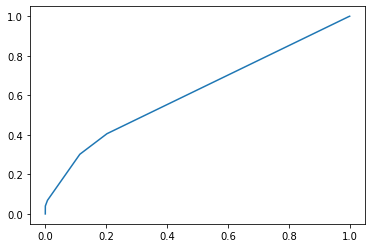

In [72]:

class GraphROC(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(GraphROC, self).__init__(*args)

    def _to_list(self, rdd):
        vars = []
        for row in rdd.collect():
            vars += [(float(row._1()), float(row._2()))]
        return vars

    def roc_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
    

preds = predictions_memory_dt.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))

# Returns as a list (false positive rate, true positive rate)
vars = GraphROC(preds).roc_curve('roc')

plt.figure()
x_val = [x[0] for x in vars]
y_val = [x[1] for x in vars]
#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.plot(x_val, y_val)

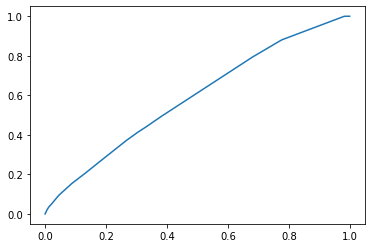

In [73]:
preds_new = predictions_process_gbt.select('attack','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))

# Returns as a list (false positive rate, true positive rate)
vars_new = GraphROC(preds_new).roc_curve('roc')

plt.figure()
x_val = [x[0] for x in vars_new]
y_val = [x[1] for x in vars_new]
#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.plot(x_val, y_val)

### 5

In [74]:
# train, test = df.randomSplit([0.9, 0.1], seed=12345)
attack3 = memory_df.filter(col('attack') == 1)
non_attack3 = memory_df.filter(col('attack') == 0)
if non_attack3.count() > attack3.count():
    ratio3 = non_attack3.count()/attack3.count()
else:
    ratio3 = attack3.count()/non_attack3.count()
# train, test = df.randomSplit([0.9, 0.1], seed=12345)
sampled_non_attack3 = non_attack3.sample(False, 1/(ratio3/2))
rebalanced_memory_train3 = sampled_non_attack3.unionAll(attack3)
rebalanced_memory_train3.groupby('attack').count().show()

+------+------+
|attack| count|
+------+------+
|   1.0|205623|
|   0.0|410959|
+------+------+



In [75]:
# train, test = df.randomSplit([0.9, 0.1], seed=12345)
attack4 = process_df.filter(col('attack') == 1)
non_attack4 = process_df.filter(col('attack') == 0)
if non_attack4.count() > attack4.count():
    ratio4 = non_attack4.count()/attack4.count()
else:
    ratio4 = attack4.count()/non_attack4.count()
# train, test = df.randomSplit([0.9, 0.1], seed=12345)
sampled_non_attack4 = non_attack4.sample(False, 1/(ratio4/2))
rebalanced_process_train4 = sampled_non_attack4.unionAll(attack4)
rebalanced_process_train4.groupby('attack').count().show()

+------+------+
|attack| count|
+------+------+
|   1.0|291364|
|   0.0|582976|
+------+------+



In [76]:
fullmodel_dt_memory = pipeline_memory_dt.fit(rebalanced_memory_train3)
fullmodel_gbt_process = pipeline_process_gbt.fit(rebalanced_process_train4)


# 3.  Knowledge sharing
 

## 3.1

In [79]:
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

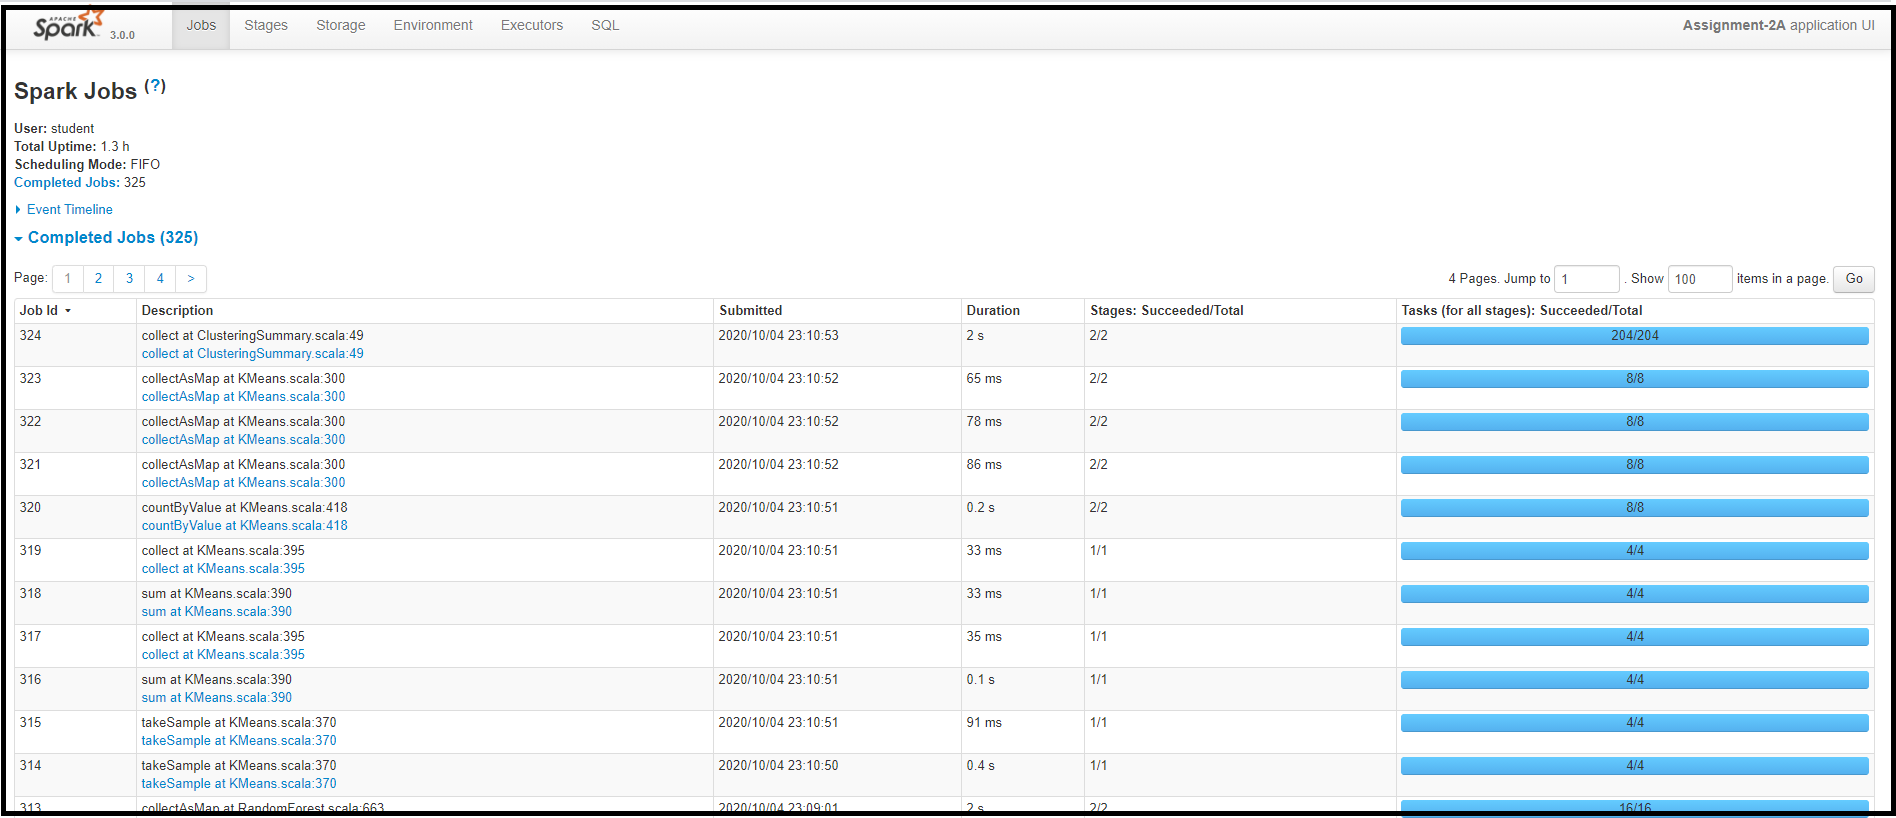

Hence there are 11 jobs observed.

## 3.2

The technique used here is Result Parallelism of K Means(as data points are transferred from one processor to anther) 

Steps followed are - 
1.  The data is given randomly to the different processors.  In this approach each processor is responsible for creating its own clusters and in the end we combine the clusters from each processor. Hence if there are 6 clusters to generate with 3 processors then each processor will create 2 clusters and finally we combine the 2 clusters from 3 processors to get 6 clusters. 
2. After getting the data, each processor finds the mean and then compares the mean value to its data points. The data points are then sent to the cluster which has the minimum distance to the mean. As a result the data points can move from one processor to another. 
3. Then with the new data, another iteration happens and the mean is calculated. The same process occurs and distance of each point to mean is calculated to send the data point to the appropriate processor's cluster. 
4. In the end when two consecutive iterations produce the same set of clusters with same mean and same data points then the process stops. 
5. Finally all the clusters generated from the different processors  are combined together to get the final clusters.

In the screenshot attached we can see that takeSample at KMeans is the one generating samples for each processor, sum at KMeans will calculate the sum and count to calculate the mean of clusters, collect at KMeans gathers the data points to the appropriate clusters, countByValue at KMeans counts the clusters generated finally in each processor, collectAsMap at KMeans collects the cluster wise data from the different processors and the last stage of collect at ClusterngSummary provides a summary of the process.